# Math 3910: Optimal Estimation and Control  |  Example LQR Code

## Problem/Assignment Overview

Consider the following optimization problem: 

\begin{align*}
& \textsf{Minimize}\qquad && J[u,x] = \int_{t_0}^{t_f}\left[\frac{1}{2}\vec{x}^{\top} Q\, \vec{x} + \frac{1}{2}\vec{u}^\top R\,\vec{u} \right]\,dt + \frac{1}{2}\vec{x}^\top G \,\vec{x}\bigg\vert_{t = t_f}\\
& \textsf{Subject to} && \dot{\vec{x}} = A\vec{x} + B\vec{u},\\
& && \vec x(t_0) = \vec x_0,\\
&&& \textsf{where } t_0 \textsf{ and } t_f \textsf{ are known.}
\end{align*}


## Summary/Outline from Class
Using Pontryagin's Maximum Principle, we can solve the optimal control problem by forming the Hamiltonian $H$ which is given by 
$$H =\frac{1}{2}\vec{x}^{\top} Q\, \vec{x} + \frac{1}{2}\vec{u}^\top R\,\vec{u}   + \vec{p}^\top \left(A\vec{x} + B \vec{u}\right)$$
where $\vec{p}$ represents our Lagrange multipliers.  Following the **Pontryagin's Principle Summary Handout**, and the work done in class, we have the following steps:

**Step 1:** We know the optimal control $\vec{u}$ in terms of $\vec{p}$ from solving the equation $$\delta u: \qquad H_u = 0 \quad \longrightarrow \quad \vec{u} = -R^{-1}B^\top \vec{p}$$

**Step 2:** We would like to solve for $\vec{p}$ and $\vec{u}$ by setting up the following equations: 
\begin{align*}
\delta x&: && \dot{\vec{p}} = -Q \vec{x} - A^\top \vec{p},\\
\delta u&: && \dot{\vec{x}} = A\vec{x} + B \vec{u},\\
\delta x_f&: && \vec{p}\big\vert_{t_f} = G \vec{x}\big\vert_{t_f},\\
\textsf{given}&:&& \vec{x}\big\vert_{t_0} = \vec{x}_0.
\end{align*}
Since the optimal control is given by $\vec{u} = -R^{-1}B^\top \vec{p}$, we can replace $\vec{u}$ in the above equations to express the above as a system of ODEs for the two unknowns $\vec{x}$ and $\vec{p}$ given by: 
$$\begin{bmatrix}\dot{\vec{x}}\\\dot{\vec{ p}}\end{bmatrix} = \begin{bmatrix} A & -BR^{-1}B^\top\\-Q & -A^\top\end{bmatrix}\begin{bmatrix}\vec{x}\\\vec{p}\end{bmatrix}, \qquad \begin{bmatrix}\vec{x}(t_0)\\\vec{p}(t_0)\end{bmatrix}=\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix}$$
The solution to the above system can be expressed in terms of the state-transition matrix $\Phi(t,t_0)$ as $$\begin{bmatrix}\vec{x}(t)\\\vec{p}(t)\end{bmatrix} = \Phi(t,t_0)\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix},$$
where the challenge is that we don't have an initial condition for $\vec{p}$, nor do we know the value of $\vec{x}$ when $t = t_f$.  

**Step 3:** We can at least determine $\vec{x}_f$ via the $\delta \vec{x}_f$ variation to find that $$\vec{p} = G\vec{x}_f.$$  Evaluating the solution to the system when $t = t_f$, we find $$\begin{bmatrix}\vec{x}_f\\\vec{p}_f\end{bmatrix} = \Phi(t_f,t_0)\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix} \quad \longrightarrow\quad \begin{bmatrix}\vec{x}_f\\ G \vec{x}_f\end{bmatrix} = \Phi(t_f,t_0)\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix}$$

**Step 4:** Despite only knowing $\vec{x}_0$ and how $\vec{p}_f$ relates to $\vec{x}_f$, we can find the state transition matrix $\Phi(t,t_0)$.  The bulk of the document is about finding these matrices and thus the solution.


## The Code

### Preliminaries and Matrix Definitions

In [13]:
from matplotlib import pyplot as plt 
import numpy as np
plt.rcParams['text.usetex'] = True

Now, let's define the matrices $A$, $B$, $Q$, $R$, and $G$ where $$A = \begin{bmatrix}1 & 0\\0 & 0\end{bmatrix}, \qquad B = \begin{bmatrix}0\\1\end{bmatrix},\qquad Q = \begin{bmatrix}\omega_1& 0\\0 & \omega_2\end{bmatrix},\qquad R = \begin{bmatrix}1\end{bmatrix}, \qquad G = Q$$

For simplicity, I will initialize the $\omega_1$ and $\omega_2$ values to be $\omega_1 = 1$ and $\omega_2 = 1$.  You are welcome to play around with these values in order to see what happens.  

In [14]:
A = np.array([[0., 1.],[0., 0.]]);
B = np.array([[0.],[1.]]);

w1 = 1.;
w2 = 1.;

Q = np.array([[w1,0.],[0., w2]]);
R = np.array([[1.]]);

G = Q;


Let's also set the initial and final times, $t_0$ and $t_f$ respectively.  Finally, we can input the initial condition $x_0$.  

In [15]:
t0 = 0;
tf = 10;
x0 = np.array([[3.],[1.]])

At this point, we will now define the number of time-steps (`numSteps`), as well the vector of $t$ values at which we will compute the solution (`tV`), and the width of each time step (`dt`).  

In [5]:
numSteps = 100;
tV = np.linspace(t0,tf,numSteps);
dt = tV[1]-tV[0];



### Numerically Solving for the Transition Matrix $\Phi(t,t_0)$
Recall that the state transition matrix $\Phi(t,t_0)$ satisfies the differential equation $$\frac{d\Phi}{dt} = \underbrace{\begin{bmatrix}A & -B R^{-1}B^\top\\-Q & -A^\top\end{bmatrix}}_{\footnotesize{K}}\Phi, \quad \Phi(t_0,t_0) = I.$$
We can use Euler's method to numerically integrate and time-step the solution for $\Phi$.  Recall that Euler's method says that $$\Phi(t_j + \Delta t,t_0) \approx \Phi(t_j,t_0) + \Delta t\cdot K \Phi(t_j,t_0) \approx (I + \Delta t\cdot K)\Phi(t_j,t_0)$$

In the following block of code, we initializes an array that will store $\Phi$ at each time step.  

In [6]:
Phi = np.zeros((numSteps,4,4));
Phi[0,:,:] = np.eye(4);

Now, we will take the prescribed number of steps (`numSteps`) to approximate the transition matrix $\Phi$ from $t_0$ to $t_f$. 

In [7]:
K = np.vstack((np.hstack((A, -B@R**(-1)@B.transpose())),np.hstack((-Q, -A.transpose()))))

for j in range(0,numSteps-1):
    t = tV[j];
    Phi[j+1,:,:] = (np.eye(4) + dt*K)@Phi[j,:,:]

# The following simply determines Phi(t_f,t_0) by taking the final computed value of Phi
PhiF = Phi[-1,:,:]
PhiF11 = PhiF[0:2,0:2];
PhiF12 = PhiF[0:2,2:4];
PhiF21 = PhiF[2:4,0:2];
PhiF22 = PhiF[2:4,2:4];




### Finding $\vec{p}_0$ and $\vec{x}_f$ using $\Phi(t_f,t_0)$.  
Recall that in class, we set up the system $$\begin{bmatrix}\vec{x}_f\\\vec{p}_f\end{bmatrix} = \begin{bmatrix} \Phi_{1,1}(t_f,t_0) & \Phi_{1,2}(t_f,t_0)\\\Phi_{2,1}(t_f,t_0) & \Phi_{2,2}(t_f,t_0)\end{bmatrix}\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix} \quad \textsf{where}\quad \vec{p}_f = G\vec{x_f}.$$ Considering the unknowns to be $\vec{x}_f$ and $\vec{p}_0$, we can rearrange the system to find $$\underbrace{\begin{bmatrix}I & -\Phi_{1,2}(t_f,t_0)\\G & -\Phi_{2,2}\end{bmatrix}}_{\textsf{\footnotesize{lhs}}}\begin{bmatrix}\vec{x}_f\\\vec{p}_0\end{bmatrix} = \underbrace{\begin{bmatrix} \Phi_{1,1}(t_f,t_0) & 0\\ \Phi_{1,2}(t_f,t_0) & 0\end{bmatrix}}_{\textsf{\footnotesize{rhs}}}\begin{bmatrix}\vec{x}_0\\\vec{p}_f\end{bmatrix}\quad \longrightarrow\quad \begin{bmatrix}\vec{x}_f\\\vec{p}_0\end{bmatrix} = \begin{bmatrix}I & -\Phi_{1,2}(t_f,t_0)\\G & -\Phi_{2,2}\end{bmatrix}^{-1}\begin{bmatrix} \Phi_{1,1}(t_f,t_0) & 0\\ \Phi_{1,2}(t_f,t_0) & 0\end{bmatrix}\begin{bmatrix}\vec{x}_0\\\vec{p}_f\end{bmatrix}$$

Because computing inverses of matrices via commands such as `inv` are computational expensive, we will use `np.linalg.solve` to solve the above system using more stable, and computational efficient methods (such as $LU$ decomposition, etc).

In [8]:
lhs1 = np.hstack((np.eye(2),-PhiF12));
lhs2 = np.hstack((G,-PhiF22));
lhs = np.vstack((lhs1,lhs2));

rhs = np.vstack((PhiF11@x0,PhiF21@x0));
output = np.linalg.solve(lhs,rhs)

# peel off the last two terms as this represents the initial condition for p.
p0 = output[2:4];

# now, create the vector of initial conditions for z = [x  p]^T
z0 = np.vstack((x0,p0));


    

Now that we have the initial conditions $\vec{z}_0 = \left[\vec{x}_0~~\vec{p}_0\right]^\top$ and the state-transition matrix $\Phi(t,t_0)$ (computed for each time step), we can find $\vec{z}$ at each time step by noting that the solution to the problem is given by $$\vec{z}(t) = \Phi(t,t_0)\vec{z}_0 \quad \textsf{and}\quad u(t) = -R^{-1}B^\top\vec{p}(t)$$

In [9]:
z = np.zeros((numSteps,4,1))
u = np.zeros((numSteps))

for j in range(0,numSteps-1):
    t = tV[j]
    z[j,:,:] = Phi[j,:,:]@z0; #computing the solution given by z(t) = Phi(t,t_0)*z0
    u[j] = -np.linalg.solve(R,B.transpose())@z[j,2:4,:]; # computing the control law u(t) = -R^(-1)B^(T)*p(t)

### Plotting the Solution/Output

Now that we have computed the control, let's see what happens when we implement this.  

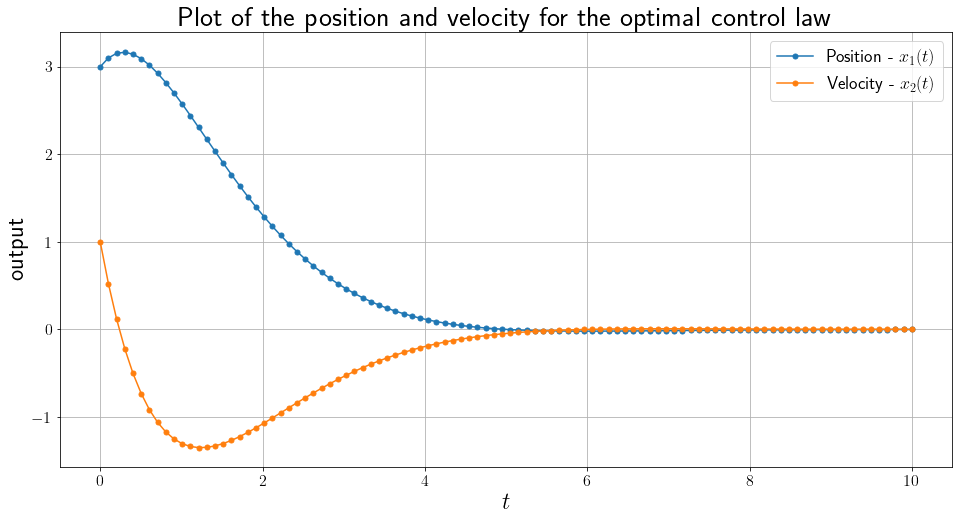

In [110]:
plt.figure(figsize=(16, 8))


plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.plot(tV,z[:,0:2,:].reshape(numSteps,2),'.-',markersize=10)
plt.legend([r'Position - $x_1(t)$','Velocity - $x_2(t)$'])
plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the position and velocity for the optimal control law',fontsize=28)
plt.grid()
plt.show()

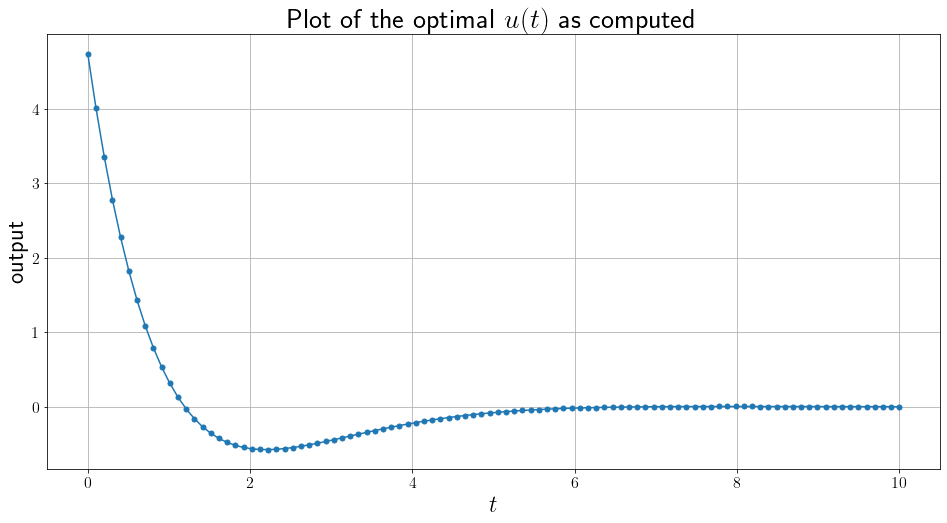

In [112]:
plt.figure(figsize=(16, 8))


plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.plot(tV,u,'.-',markersize=10)
plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the optimal $u(t)$ as computed',fontsize=28)
plt.grid()
plt.show()